# Multivariate quantiles and long horizon forecasting with N-HiTS


In [1]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MQF2DistributionLoss, QuantileLoss

/opt/conda/lib/python3.8/site-packages/pytorch_forecasting/models/base_model.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Load data


We generate a synthetic dataset to demonstrate the network's capabilities. The data consists of a quadratic trend and a seasonality component.


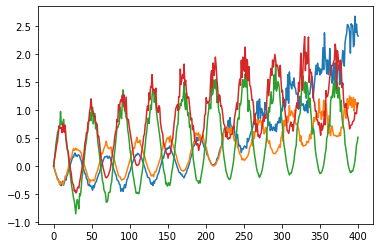

In [23]:
import matplotlib.pyplot as plt

data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
data["static"] = 2
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
data.head()
plt.plot(np.linspace(0, 400, 400), data[data.series==0]['value'])
plt.plot(np.linspace(0, 400, 400), data[data.series==1]['value'])
plt.plot(np.linspace(0, 400, 400), data[data.series==2]['value'])
plt.plot(np.linspace(0, 400, 400), data[data.series==3]['value'])
# len(data)
data.to_csv('test_seasonal_ar_data.csv')

In [24]:
# create dataset and dataloaders
max_encoder_length = 30
max_prediction_length = 7

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-HiTS can also not take any additional variables
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## Calculate baseline error


In [30]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)
print(baseline_predictions.output)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


torch.Size([100, 7])


## Train network


In [31]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=0.1)
net = NHiTS.from_dataset(
    training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/opt/conda/lib/python3.8/site-packages/lightning/pytorch/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/opt/conda/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn

suggested learning rate: 0.00630957344480193


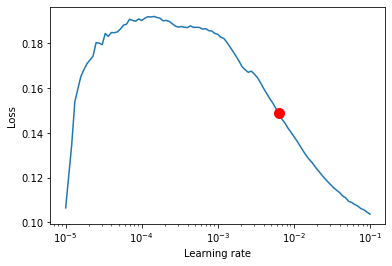

In [32]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e-1)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

Fit model


In [33]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
from lightning.pytorch import loggers as pl_loggers
tensorboard = pl_loggers.TensorBoardLogger('./')

trainer = pl.Trainer(
    max_epochs=30,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
    logger=tensorboard
)

net = NHiTS.from_dataset(
    training,
    learning_rate=5e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type                 | Params
---------------------------------------------------------
0 | loss            | MQF2DistributionLoss | 3.0 K 
1 | logging_metrics | ModuleList           | 0     
2 | embeddings      | MultiEmbedding       | 0     
3 | model           | NHiTS                | 24.8 K
---------------------------------------------------------
27.8 K    Trainable params
0         Non-trainable params
27.8 K    Total params
0.111     Total estimated model params size (MB)


Epoch 0:  80%|████████  | 40/50 [00:08<00:02,  4.98it/s, v_num=18, train_loss_step=0.0566]

Finding best initial lr: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


Epoch 0: 100%|██████████| 50/50 [00:10<00:00,  4.91it/s, v_num=18, train_loss_step=0.0527]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 50/50 [00:10<00:00,  5.00it/s, v_num=18, train_loss_step=0.0359, val_loss=0.0932, train_loss_epoch=0.0747]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 50/50 [00:10<00:00,  4.77it/s, v_num=18, train_loss_step=0.0463, val_loss=0.0772, train_loss_epoch=0.0435]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 50/50 [00:10<00:00,  4.73it/s, v_num=18, train_loss_step=0.033, val_loss=0.075, train_loss_epoch=0.041]  
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 50/50 [00:10<00:00,  4.99it/s, v_num=18, train_loss_step=0.0416, val_loss=0.0739, train_loss_epoch=0.0409]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 50/50 [00:10<00:00,  4.88it/s, v_num=18, train_loss_step=0.0335, val_loss=0.0779, train_loss_epoch=0.040] 
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 50/50 [00:10<00:00,  4.96it/s, v_

### Evaluate Results


In [34]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)

In [144]:
nhits_predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
nhits_forecast = nhits_predictions.output
MAE()(predictions.output, predictions.y)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.2241)

Looking at random samples from the validation set is always a good way to understand if the forecast is reasonable - and it is!


In [143]:
# raw_nbits_predictions = best_model.predict(val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))
# for idx in range(10):  # plot 10 examples
#     plt.plot(np.arange(-30, 0, 1), raw_nbits_predictions.x['encoder_target'][idx])
#     best_model.plot_prediction(raw_nbits_predictions.x, raw_nbits_predictions.output, idx=idx, add_loss_to_title=True)

## N-Beats model

In [97]:
import os
from argparse import ArgumentParser

import matplotlib.pyplot as plt
import torch
from torch import optim
from torch.nn import functional as F

from data import get_m4_data, dummy_data_generator
from nbeats_pytorch.model import NBeatsNet

CHECKPOINT_NAME = 'nbeats-training-checkpoint.th'

def split(arr, size):
    arrays = []
    while len(arr) > size:
        slice_ = arr[:size]
        arrays.append(slice_)
        arr = arr[size:]
    arrays.append(arr)
    return arrays


def batcher(dataset, batch_size, infinite=False):
    while True:
        x, y = dataset
        for x_, y_ in zip(split(x, batch_size), split(y, batch_size)):
            yield x_, y_
        if not infinite:
            break


def main(test=0):
    device = torch.device('cpu')
    forecast_length = 7
    backcast_length = 30
    batch_size = 4  # greater than 4 for viz
    task = 'ar'
    if task == 'm4':
        data_gen = batcher(get_m4_data(backcast_length, forecast_length), batch_size=batch_size, infinite=True)
    elif task == 'dummy':
        data_gen = dummy_data_generator(backcast_length, forecast_length,
                                        signal_type='seasonality', random=True,
                                        batch_size=batch_size)
    elif task == 'ar':
        tmp = best_model.predict(train_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))
        training_x = tmp.x['encoder_target']
        training_target = tmp.x['decoder_target']
        data_gen = (training_x, training_target)
    else:
        raise Exception('Unknown task.')

    print('--- Model ---')
    net = NBeatsNet(device=device,
                    stack_types=[NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK, NBeatsNet.GENERIC_BLOCK],
                    forecast_length=forecast_length,
                    thetas_dim=[2, 8, 3],
                    nb_blocks_per_stack=3,
                    backcast_length=backcast_length,
                    hidden_layer_units=1024,
                    share_weights_in_stack=False,
                    nb_harmonics=None)

    optimiser = optim.Adam(net.parameters())

    def plot_model(x, target, grad_step):
        print('plot()')
        plot(net, x, target, backcast_length, forecast_length, grad_step)

    max_grad_steps = 12000
    if test:
        max_grad_steps = 5

    simple_fit(net, optimiser, data_gen, task, plot_model, device, max_grad_steps)


def simple_fit(net, optimiser, data_generator, task, on_save_callback=None, device=torch.device('cpu'), max_grad_steps=12000):
    print('--- Training ---')
    initial_grad_step = load(net, optimiser)
    if task == 'm4' or task == 'dummy':
        for grad_step, (x, target) in enumerate(data_generator):
            grad_step += initial_grad_step
            optimiser.zero_grad()
            net.train()
            backcast, forecast = net(torch.tensor(x, dtype=torch.float).to(device))
            loss = F.mse_loss(forecast, torch.tensor(target, dtype=torch.float).to(device))
            loss.backward()
            optimiser.step()
            print(f'grad_step = {str(grad_step).zfill(6)}, loss = {loss.item():.6f}')
            if grad_step % 1000 == 0 or (grad_step < 1000 and grad_step % 100 == 0):
                with torch.no_grad():
                    save(net, optimiser, grad_step)
                    if on_save_callback is not None:
                        on_save_callback(x, target, grad_step)
            if grad_step > max_grad_steps:
                print('Finished.')
                break
    if task == 'ar':
        train_x, train_target = data_generator
        n_samples = training_x.shape[0]
        batch_size = 32
        for grad_step in range(max_grad_steps):
            idf = np.random.choice(n_samples, batch_size)
            x, target = train_x[idf], train_target[idf]
            grad_step += initial_grad_step
            optimiser.zero_grad()
            net.train()
            backcast, forecast = net(torch.tensor(x, dtype=torch.float).to(device))
            loss = F.mse_loss(forecast, torch.tensor(target, dtype=torch.float).to(device))
            loss.backward()
            optimiser.step()
            print(f'grad_step = {str(grad_step).zfill(6)}, loss = {loss.item():.6f}')
            if grad_step % 1000 == 0 or (grad_step < 1000 and grad_step % 100 == 0):
                print('Saving model')
                torch.save(net, 'Nbeats_model.h5')
                with torch.no_grad():
                    save(net, optimiser, grad_step)
                    if on_save_callback is not None:
                        on_save_callback(x, target, grad_step)
            if grad_step > max_grad_steps:
                print('Finished.')
                break


def save(model, optimiser, grad_step=0):
    torch.save({
        'grad_step': grad_step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimiser.state_dict(),
    }, CHECKPOINT_NAME)


def load(model, optimiser):
    if os.path.exists(CHECKPOINT_NAME):
        checkpoint = torch.load(CHECKPOINT_NAME)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimiser.load_state_dict(checkpoint['optimizer_state_dict'])
        grad_step = checkpoint['grad_step']
        print(f'Restored checkpoint from {CHECKPOINT_NAME}.')
        return grad_step
    return 0


def plot(net, x, target, backcast_length, forecast_length, grad_step):
    net.eval()
    _, f = net(torch.tensor(x, dtype=torch.float))
    subplots = [221, 222, 223, 224]

    plt.figure(1)
    plt.subplots_adjust(top=0.88)
    for i in range(4):
        ff, xx, yy = f.cpu().numpy()[i], x[i], target[i]
        plt.subplot(subplots[i])
        plt.plot(range(0, backcast_length), xx, color='b')
        plt.plot(range(backcast_length, backcast_length + forecast_length), yy, color='g')
        plt.plot(range(backcast_length, backcast_length + forecast_length), ff, color='r')
        # plt.title(f'step #{grad_step} ({i})')

    output = 'n_beats_{}.png'.format(grad_step)
    plt.savefig(output)
    plt.clf()
    print('Saved image to {}.'.format(output))


if __name__ == '__main__':
    main()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


--- Model ---
| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=1024, thetas_dim=2, backcast_length=30, forecast_length=7, share_thetas=True) at @140330554963904
     | -- TrendBlock(units=1024, thetas_dim=2, backcast_length=30, forecast_length=7, share_thetas=True) at @140330554965632
     | -- TrendBlock(units=1024, thetas_dim=2, backcast_length=30, forecast_length=7, share_thetas=True) at @140330373414816
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=1024, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @140330373414864
     | -- SeasonalityBlock(units=1024, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @140330373411936
     | -- SeasonalityBlock(units=1024, thetas_dim=7, backcast_length=30, forecast_length=7, share_thetas=True) at @140330373413184
| --  Stack Generic (#2) (share_weights_in_stack=False)
     | -- GenericBlock(units=1024, the

<ipython-input-97-1ce9e979aaf6>:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  backcast, forecast = net(torch.tensor(x, dtype=torch.float).to(device))
<ipython-input-97-1ce9e979aaf6>:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = F.mse_loss(forecast, torch.tensor(target, dtype=torch.float).to(device))


grad_step = 010000, loss = 0.043240
plot()


<ipython-input-97-1ce9e979aaf6>:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, f = net(torch.tensor(x, dtype=torch.float))


Saved image to n_beats_10000.png.
grad_step = 010001, loss = 0.112926
grad_step = 010002, loss = 0.057611
grad_step = 010003, loss = 0.088803
grad_step = 010004, loss = 0.027265
grad_step = 010005, loss = 0.048990
grad_step = 010006, loss = 0.107995
grad_step = 010007, loss = 0.061580
grad_step = 010008, loss = 0.049837
grad_step = 010009, loss = 0.076092
grad_step = 010010, loss = 0.029403
grad_step = 010011, loss = 0.014876
grad_step = 010012, loss = 0.060917
grad_step = 010013, loss = 0.110756
grad_step = 010014, loss = 0.026183
grad_step = 010015, loss = 0.156285
grad_step = 010016, loss = 0.078251
grad_step = 010017, loss = 0.076601
grad_step = 010018, loss = 0.093588
grad_step = 010019, loss = 0.056597
grad_step = 010020, loss = 0.037335
grad_step = 010021, loss = 0.125741
grad_step = 010022, loss = 0.041459
grad_step = 010023, loss = 0.039825
grad_step = 010024, loss = 0.028400
grad_step = 010025, loss = 0.093492
grad_step = 010026, loss = 0.069836
grad_step = 010027, loss = 0.0

<Figure size 432x288 with 0 Axes>

In [89]:
tmp = best_model.predict(val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))
testing_x = tmp.x['encoder_target']
testing_target = tmp.x['decoder_target']
model = torch.load('Nbeats_model.h5')
nbeats_backcast, nbeats_forecast = model(torch.tensor(testing_x, dtype=torch.float))
nbeats_backcast = nbeats_backcast.detach()
nbeats_forecast = nbeats_forecast.detach()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
<ipython-input-89-bfe3f919a388>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tesing_backcast, testing_forecast = net(torch.tensor(testing_x, dtype=torch.float))


IndexError: too many indices for tensor of dimension 2

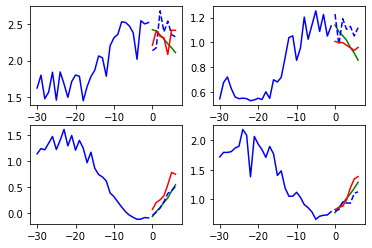

In [142]:
subplots = [221, 222, 223, 224]
plt.figure(1)
plt.subplots_adjust(top=0.88)
for i in range(4):
    plt.subplot(subplots[i])
    plt.plot(range(-30, 0, 1), testing_x[i], color='b')
    plt.plot(range(0, 7, 1), nhits_forecast[i], color='g')
    plt.plot(range(0, 7, 1), testing_target[i], color='blue', linestyle='dashed')
    plt.plot(range(0, 7, 1), nbeats_forecast[i], color='r')

## Interpret model


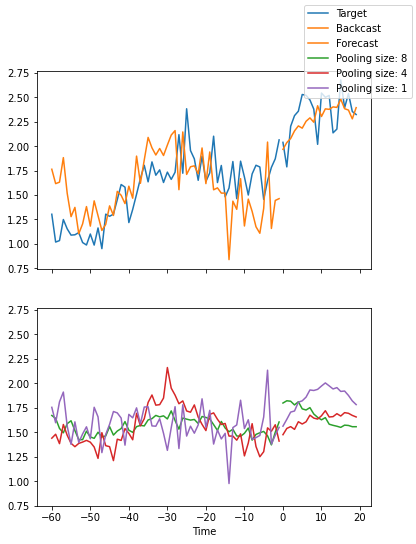

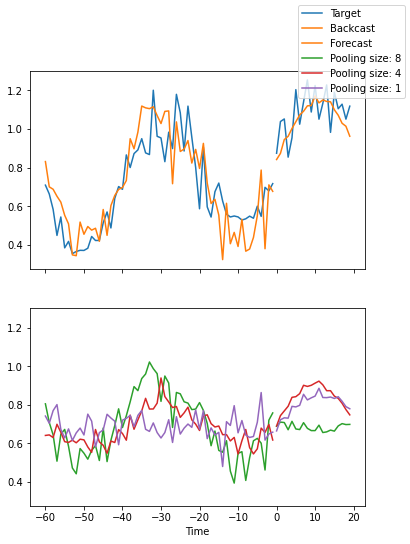

In [12]:
for idx in range(2):  # plot 10 examples
    best_model.plot_interpretation(raw_predictions.x, raw_predictions.output, idx=idx)

## Sampling from predictions


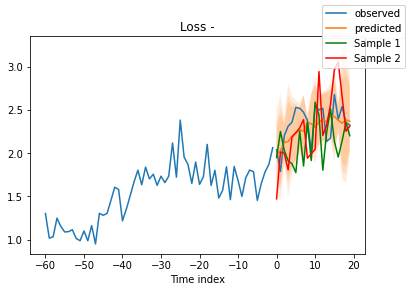

In [13]:
# sample 500 paths
samples = best_model.loss.sample(raw_predictions.output["prediction"][[0]], n_samples=500)[0]

# plot prediction
fig = best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)
ax = fig.get_axes()[0]
# plot first two sampled paths
ax.plot(samples[:, 0], color="g", label="Sample 1")
ax.plot(samples[:, 1], color="r", label="Sample 2")
fig.legend()

As expected, the variance of predictions is smaller within each sample than accross all samples.


In [14]:
print(f"Var(all samples) = {samples.var():.4f}")
print(f"Mean(Var(sample)) = {samples.var(0).mean():.4f}")

Var(all samples) = 0.1007
Mean(Var(sample)) = 0.0926


We can now do something new and plot the distribution of sums of forecasts over the entire prediction range.


Text(0, 0.5, 'Frequency')

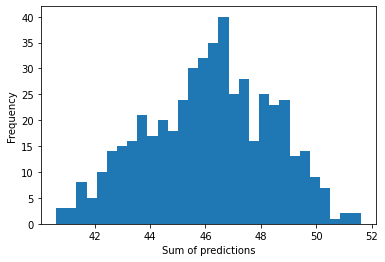

In [15]:
plt.hist(samples.sum(0).numpy(), bins=30)
plt.xlabel("Sum of predictions")
plt.ylabel("Frequency")

In [43]:
for i in range(10):
    print(val_dataloader.dataset.data)

{'reals': tensor([[-1.1085],
        [-0.6461],
        [-1.4935],
        ...,
        [-1.1736],
        [-1.3123],
        [-0.0387]]), 'categoricals': tensor([], size=(3700, 0), dtype=torch.int64), 'groups': tensor([[ 0],
        [ 0],
        [ 0],
        ...,
        [99],
        [99],
        [99]]), 'target': [tensor([ 1.6274,  1.8022,  1.4819,  ..., -5.6302, -5.7451, -4.6900])], 'weight': None, 'time': tensor([363, 364, 365,  ..., 397, 398, 399])}
{'reals': tensor([[-1.1085],
        [-0.6461],
        [-1.4935],
        ...,
        [-1.1736],
        [-1.3123],
        [-0.0387]]), 'categoricals': tensor([], size=(3700, 0), dtype=torch.int64), 'groups': tensor([[ 0],
        [ 0],
        [ 0],
        ...,
        [99],
        [99],
        [99]]), 'target': [tensor([ 1.6274,  1.8022,  1.4819,  ..., -5.6302, -5.7451, -4.6900])], 'weight': None, 'time': tensor([363, 364, 365,  ..., 397, 398, 399])}
{'reals': tensor([[-1.1085],
        [-0.6461],
        [-1.4935],
       

In [44]:
loader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [54]:
loader.dataset.data['target'][0].shape

torch.Size([3700])

In [55]:
loader.dataset.data['target'][0]

tensor([ 1.6274,  1.8022,  1.4819,  ..., -5.6302, -5.7451, -4.6900])